<a href="https://colab.research.google.com/github/terryspitz/3D/blob/master/deeper/fonttools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loads TrueType fonts using https://pypi.org/project/TTFQuery/ (Py3 version from https://github.com/mindw/ttfquery), and triangulates them using https://rufat.be/triangle/ library, and Shapely https://shapely.readthedocs.io/en/stable/manual.html for geometry.
Builds a Triangle Stack, a list of points with implicit rules for building a triangled font glyph (character) from the points as follows:

1. Each element consists of an optional point and an optional triangle (represented by 2 bools).
2. If present the point (x, y floats) is added to a stack.
3. If present the triangle is represented by the latest point and two relative offsets in the stack (2 ints)

#TODO
Import from Google Fonts https://developers.google.com/fonts/docs/developer_api or https://github.com/google/fonts/archive/master.zip


In [0]:
#@title Imports
#jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888
#from enum import Enum, IntEnum
from copy import copy
import math
import os
import glob 
#import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
print("np", np.__version__)
print("tf", tf.__version__)
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageChops
from IPython.display import display

#!pip install triangle
import triangle as tr
print("tr", tr.__version__)

#!pip install fonttools
#from fontTools.ttLib import TTFont

# should be:
#!pip install ttfquery
# or 
#!conda install -c mwcraig ttfquery
# but actually had to:
#git clone git@github.com:mindw/ttfquery.git
#cd ttfquery
#python setup.py install

import ttfquery.describe
import ttfquery.glyph
import ttfquery.findsystem
print("ttfquery", ttfquery.__version__)

#!pip install shapely
# or on windows:
#!conda config --add channels conda-forge
#!conda install shapely
import shapely.ops
import shapely.geometry
import shapely.affinity
print("shapely", shapely.__version__)

#!pip install descartes
import descartes


#Mar2019:
# np 1.14.2
# tf 1.10.0
# tr 20190115.1
# ttfquery 1.0.5
# shapely 1.6.4.post2

np 1.16.2
tf 1.13.1
tr 20190115.1
ttfquery 1.0.5
shapely 1.6.4.post2


In [0]:
def readFonts(files: [str], glyphs: str): # type: List(List[MultiPolygon))
  print('loading {} files'.format(len(files)))
  tolerance = 0.001
  fonts = []
  for fontfile in files:
    font = ttfquery.describe.openFont(fontfile)
    multipolys = []
    for glyph in glyphs:
      g = ttfquery.glyph.Glyph(glyph)
      g.compile(font, steps=2)
      contours = [shapely.geometry.LinearRing(contour) for contour in g.outlines]
      #contours = [shapely.geometry.LinearRing(contour) for contourflags in g.calculateContours(font) for contour, flag in contourflags]
      size = 1.0
      contours = [shapely.affinity.scale(contour, size/g.height, size/g.height, origin=(0,0.1))
                  for contour in contours]
      polys = []
      holes = []
      # Find contours inside other contours and make them holes
      for contour in contours:
        for i, poly in enumerate(polys):
          if shapely.geometry.Polygon(contour).contains(shapely.geometry.Polygon(poly)):
            #replace
            polys[i] = contour
            holes[i].append(poly)
            break
          elif shapely.geometry.Polygon(poly).contains(shapely.geometry.Polygon(contour)):
            holes[i].append(contour)
            break
        else:
          polys.append(contour)
          holes.append([])
      multipolys.append(shapely.geometry.MultiPolygon(
          [shapely.geometry.Polygon(poly, hole).simplify(tolerance) for poly, hole in zip(polys, holes)]))
    fonts.append(multipolys)
  return fonts

In [0]:
print('setup...')
glyphs = [chr(i) for i in range(ord('A'), ord('Z')+1)]
glyphs += [chr(i) for i in range(ord('a'), ord('z')+1)]
glyphs += ['zero','one','two','three','four','five','six','seven','eight','nine']
#glyphs = ['A','B','a','b','one','two']
#glyphs += ['one','two','one','two']
#glyphs = ['A'] + glyphs
#glyphs = ['A','B','i','g','eight']
#glyphs = ['A']
max_outline_points = 200
#files = glob.glob('deeper/fonts/*.ttf')
files = list(ttfquery.findsystem.findFonts())
np.random.seed(2)
np.random.shuffle(files)
files = files[0:5]
print(files)
fonts = readFonts(files, glyphs)
#print(fonts[0][0])
#drawOutlines(vertices, segments, )

setup...
['c:\\windows\\fonts\\tcmi____.ttf', 'C:\\WINDOWS\\Fonts\\constan.ttf', 'C:\\WINDOWS\\Fonts\\ArialNova-LightItalic.ttf', 'c:\\windows\\fonts\\erasdemi.ttf', 'c:\\windows\\fonts\\ntailub.ttf']
loading 5 files


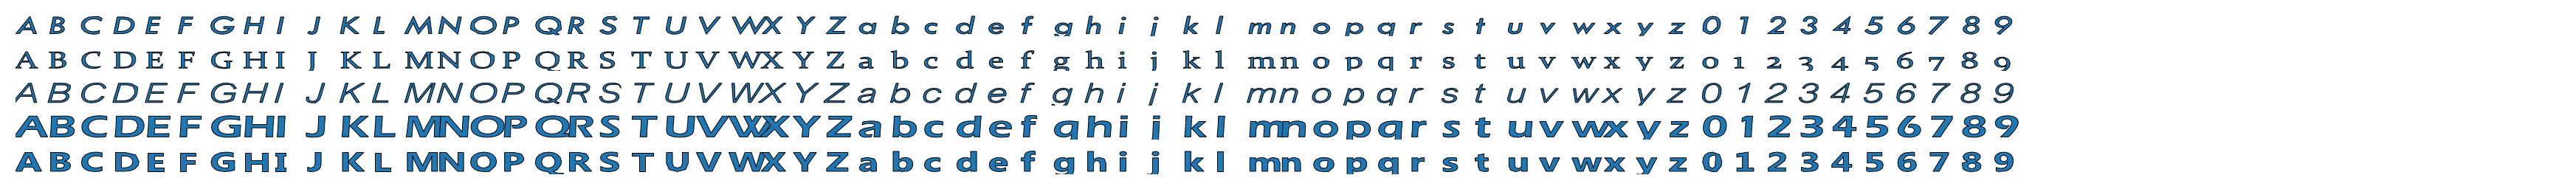

In [0]:
def drawMultiPolygons(polygons):
  fonts = len(polygons)
  glyphs = max([len(polygon) for polygon in polygons])
  plt.figure(figsize=(glyphs,fonts))
  for f in range(fonts):
    ax = plt.subplot(fonts+1, 1, 1+f)
    ax.set_xlim(0, glyphs+1)
    ax.set_axis_off()
    for glyph in range(glyphs):
      ax.add_patch(descartes.PolygonPatch(
          shapely.affinity.translate(polygons[f][glyph], glyph*0.8)
      ))
  plt.show()

drawMultiPolygons(fonts)


In [0]:
# Shapely triangulation doesn't handle holes, so use tr module instead
#triangles = shapely.ops.triangulate(fonts[0][0])

def add_poly(coords, vertices, segments):
  start = len(vertices)
  vertices += coords[:-1]
  segments += [(i, i+1) for i in range(start, start+len(coords)-2)]
  segments.append((start+len(coords)-2, start))
  
nptris = np.empty((len(fonts), len(glyphs)), dtype=dict)
for f in range(len(fonts)):
  for g in range(len(glyphs)):
    vertices = []
    segments = []
    holes = []
    for poly in fonts[f][g]:
      add_poly(poly.exterior.coords, vertices, segments)
      for interior in poly.interiors:
        add_poly(interior.coords, vertices, segments)
        holes.append(shapely.geometry.Polygon(interior).representative_point().coords[:])
    T = {
      'vertices': np.array(vertices),
      'segments': np.array(segments),
    }
    if holes:
      T['holes'] = np.array(holes).reshape((-1,2))

    opts='p'  # PSLG (see https://rufat.be/triangle/delaunay.html)
    #opts += 'q20' # conforming constrained Delaunay triangulation of a PSLG 
    #opts += 'D' # conforming Delaunay triangulation 
    nptris[f,g] = tr.triangulate(T, opts)
    #print(f, g, len(vertices), nptris[f,g]['triangles'].shape)

counts = [(glyphs[g],
           nptris[f,g]['vertices'].size,
           nptris[f,g]['triangles'].size,
           np.bincount(nptris[f,g]['triangles'].flatten()).max(),
           (np.bincount(nptris[f,g]['triangles'].flatten())==np.bincount(nptris[f,g]['triangles'].flatten()).max()).sum(),
          )
          for f in range(len(fonts)) for g in range(len(glyphs))]
print(counts)
print([max(v[i] for v in counts) for i in range(len(counts[0]))])
print([c for c in counts if c[3]>6])
print([c for c in counts if c[4]>8])
  #plt.figure(figsize=(50,2))
  # tr.plot(ax,
  #         vertices=[p for poly in triangles for p in poly.exterior.coords],
  #         triangles=[(i, i+1, i+2) for i in range(len(triangles))]
  #        )
  # for i,poly in enumerate(triangles):
  #   ax = plt.subplot(1, len(triangles), 1+i)
  #   ax.add_patch(descartes.PolygonPatch(poly))
  #plt.show()

[('A', 20, 30, 5, 1), ('B', 70, 111, 5, 1), ('C', 50, 69, 4, 4), ('D', 48, 72, 4, 4), ('E', 24, 30, 4, 3), ('F', 20, 24, 4, 3), ('G', 66, 93, 5, 1), ('H', 24, 30, 5, 1), ('I', 8, 6, 2, 2), ('J', 32, 42, 5, 1), ('K', 22, 27, 5, 2), ('L', 12, 12, 4, 1), ('M', 20, 24, 4, 3), ('N', 16, 18, 4, 2), ('O', 60, 90, 4, 6), ('P', 46, 69, 5, 1), ('Q', 80, 120, 6, 1), ('R', 52, 78, 5, 1), ('S', 86, 123, 4, 4), ('T', 16, 18, 4, 2), ('U', 48, 66, 4, 4), ('V', 12, 12, 4, 1), ('W', 20, 24, 4, 3), ('X', 24, 30, 5, 2), ('Y', 18, 21, 5, 1), ('Z', 16, 18, 4, 2), ('a', 64, 96, 5, 1), ('b', 68, 102, 5, 2), ('c', 50, 69, 4, 4), ('d', 68, 102, 6, 1), ('e', 58, 87, 5, 2), ('f', 42, 57, 5, 2), ('g', 94, 141, 5, 1), ('h', 52, 72, 7, 1), ('i', 38, 45, 7, 1), ('j', 38, 45, 6, 1), ('k', 22, 27, 5, 2), ('l', 8, 6, 2, 2), ('m', 72, 102, 6, 1), ('n', 52, 72, 5, 1), ('o', 60, 90, 4, 4), ('p', 64, 96, 6, 2), ('q', 62, 93, 6, 1), ('r', 38, 51, 5, 1), ('s', 84, 120, 4, 6), ('t', 24, 30, 5, 2), ('u', 42, 57, 5, 1), ('v', 12

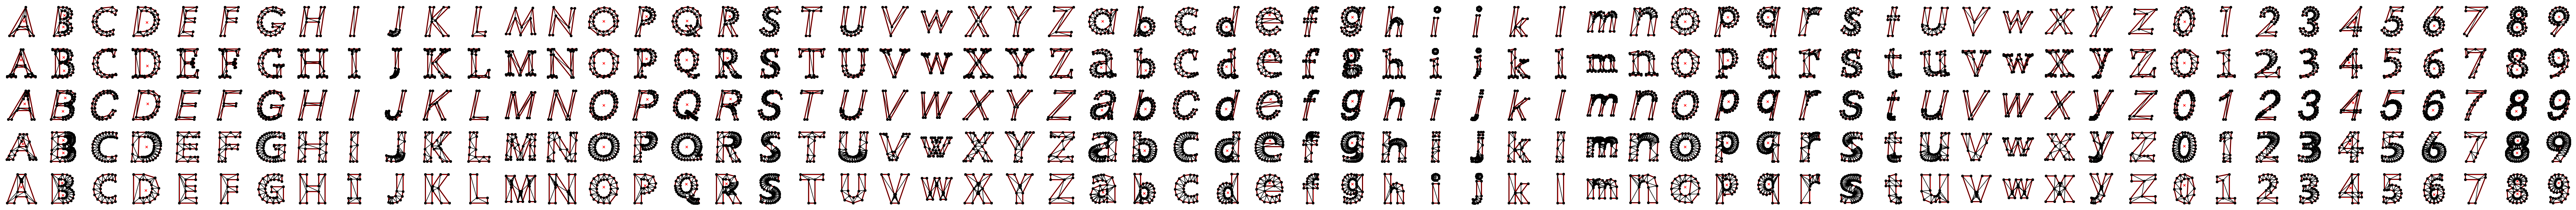

In [0]:
def drawTris(nptris):
  shape = nptris.shape
  plt.figure(figsize=(shape[1]*2,shape[0]*2))
  for f in range(shape[0]):
    for g in range(shape[1]):
      if nptris[f,g]:
        ax = plt.subplot(shape[0], shape[1], f*shape[1]+g+1)
        #ax.set_xlim(0, shape[1]+1)
        ax.set_axis_off()
        tr.plot(ax, **nptris[f,g])
        #tr.plot(ax, vertices=nptris[f,g]['vertices'])
        #ax.add_patch(descartes.PolygonPatch(
        #  shapely.affinity.translate(polygons[font][glyph], glyph*0.8)
        #))
  #plt.tight_layout()
  plt.show()

drawTris(nptris)


('C', 50, 69, 4, 4)
69


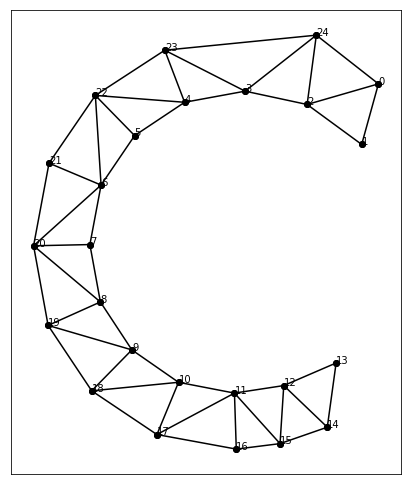

In [0]:
f,g=0,glyphs.index('C')
#print(nptris[f,g]['triangles'][0:10])
print(counts[f*len(glyphs)+g])
print(np.bincount(nptris[f,g]['triangles'].flatten()).sum())
plt.figure(figsize=(7,9))
ax = plt.subplot(111)
tr.plot(ax, vertices=nptris[f,g]['vertices'],
        triangles=nptris[f,g]['triangles'],
       labels=1)
plt.show()

In [0]:
class TriangleStack(object):
  MAXINT = 9999
  
  def __init__(self):
    self._vertices = []
    self._vertex_use_counts = []
    self._vertex_index_to_old_index = []
    
  def get_triangles(self, debug=False):
    if debug:
      print("\ndisplay")
    out_triangles = []
    next_triangle = []
    unused_vertex_indices = range(len(self._vertices))
    vertex_use_counts = copy(self._vertex_use_counts)
    if debug:
      print("vertex_use_counts: ", vertex_use_counts)
    
    for vi, v in enumerate(unused_vertex_indices):
      next_triangle.append(v)
      if debug:
        print(vi, v, next_triangle)
      
      if len(next_triangle)==3:
        out_triangles.append(next_triangle)
        if debug:
            print("out: ", out_triangles)
        for i in next_triangle:
          vertex_use_counts[i] -= 1
        if debug:
          print("vertex_use_counts: ", vertex_use_counts)
        next_triangle = []
        for i in reversed(range(vi+1)):
          if vertex_use_counts[i]>0:
            next_triangle.append(i)
            if len(next_triangle)==2:
              break
        if debug:
          print(next_triangle)
    return {'vertices': triStack._vertices, 'triangles': out_triangles}

    
  def add_triangles(self, nptri, debug_limit=MAXINT):
    print("\nadd_triangles")
    def add(index, vertex, triangle_count):
      self._vertices.append(vertex)
      self._vertex_use_counts.append(triangle_count)
      self._vertex_index_to_old_index.append(index)
    vertices = nptri['vertices']
    triangles = nptri['triangles']
    #print(vertices)
    #print(triangles)
    sorted_triangles = np.sort(triangles, axis=1)
    print(sorted_triangles)
    vertex_use_counts = np.bincount(triangles.flatten())
    print(vertex_use_counts)
    index = vertex_use_counts.argmin()
    prev_index = self.MAXINT
    while vertex_use_counts.min()<self.MAXINT and len(self._vertices)<debug_limit:
      assert vertex_use_counts[index]!=self.MAXINT
      print("adding: v %d, count %d" % (index, vertex_use_counts[index]))
      add(index, vertices[index], vertex_use_counts[index])
      checked, failed_triangle = self.check_triangles_match(vertices, sorted_triangles)
      if not checked:
        print("failed check with: ", failed_triangle) 
        break
      vertex_use_counts[index] = self.MAXINT
      # print("vertex_use_counts: ", vertex_use_counts)
      unfinished_triangles = triangles[vertex_use_counts[triangles].min(axis=1)!=self.MAXINT]
      if not unfinished_triangles.size:
        break
      new_index = self.find_most_matches(unfinished_triangles, vertex_use_counts, index, prev_index)
      #new_index = self.find_closest_to_new(unfinished_triangles, vertex_use_counts, index, prev_index)
      prev_index = index
      index = new_index
    print("finshed?: ", checked)
      
  def find_most_matches(self, unfinished_triangles, vertex_use_counts, index, prev_index):
    matches = (unfinished_triangles==index) + (unfinished_triangles==prev_index)
    matches = matches.sum(axis=1)
    triangle_index = matches.argmax()
    matching_triangle = unfinished_triangles[triangle_index]
    print("unfinished: ", unfinished_triangles)
    print("matches: ", matches, triangle_index, matching_triangle)
    triangle_counts = vertex_use_counts[matching_triangle]
    tri_vert_index = triangle_counts.argmin()
    print("matching counts: ", triangle_counts, tri_vert_index, matching_triangle[tri_vert_index])
    return matching_triangle[tri_vert_index]

  def check_triangles_match(self, old_vertices, old_triangles):
    get_triangles = self.get_triangles()
    new_triangles = get_triangles['triangles']
    #for triangle in new_triangles:
    if new_triangles:
      triangle = new_triangles[-1]
      new_old_vertices = sorted(self._vertex_index_to_old_index[index]
                                for index in triangle)
      checked = (new_old_vertices == old_triangles).all(axis=1).any()
      #print("check:", triangle, new_old_vertices, checked)
      return checked, triangle
    else:
      return True, []

triStack = TriangleStack()
glyph = nptris[0,glyphs.index('C')]
triStack.add_triangles(glyph)
triangles = triStack.get_triangles(debug=True)





add_triangles
[[ 8 19 20]
 [ 9 18 19]
 [ 8  9 19]
 [ 9 10 18]
 [ 7  8 20]
 [ 6 21 22]
 [ 6  7 20]
 [ 6 20 21]
 [ 4 22 23]
 [ 4  5 22]
 [ 5  6 22]
 [10 17 18]
 [10 11 17]
 [11 16 17]
 [11 15 16]
 [12 14 15]
 [12 13 14]
 [11 12 15]
 [ 2  3 24]
 [ 3 23 24]
 [ 0  1  2]
 [ 0  2 24]
 [ 3  4 23]]
[2 1 3 3 3 2 4 2 3 3 3 4 3 1 2 3 2 3 3 3 4 2 4 3 3]
adding: v 1, count 1
unfinished:  [[ 8 20 19]
 [ 9 19 18]
 [19  9  8]
 [10  9 18]
 [20  8  7]
 [22 21  6]
 [ 6 20  7]
 [21 20  6]
 [22  4 23]
 [ 5  4 22]
 [ 5 22  6]
 [10 18 17]
 [17 11 10]
 [11 17 16]
 [11 16 15]
 [15 14 12]
 [12 14 13]
 [15 12 11]
 [ 3  2 24]
 [ 3 24 23]
 [ 0  2  1]
 [24  2  0]
 [ 3 23  4]]
matches:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0] 20 [0 2 1]
matching counts:  [   2    3 9999] 0 0
adding: v 0, count 2
unfinished:  [[ 8 20 19]
 [ 9 19 18]
 [19  9  8]
 [10  9 18]
 [20  8  7]
 [22 21  6]
 [ 6 20  7]
 [21 20  6]
 [22  4 23]
 [ 5  4 22]
 [ 5 22  6]
 [10 18 17]
 [17 11 10]
 [11 17 16]
 [11 16 15]
 [15 14 12]
 [12 14 13]

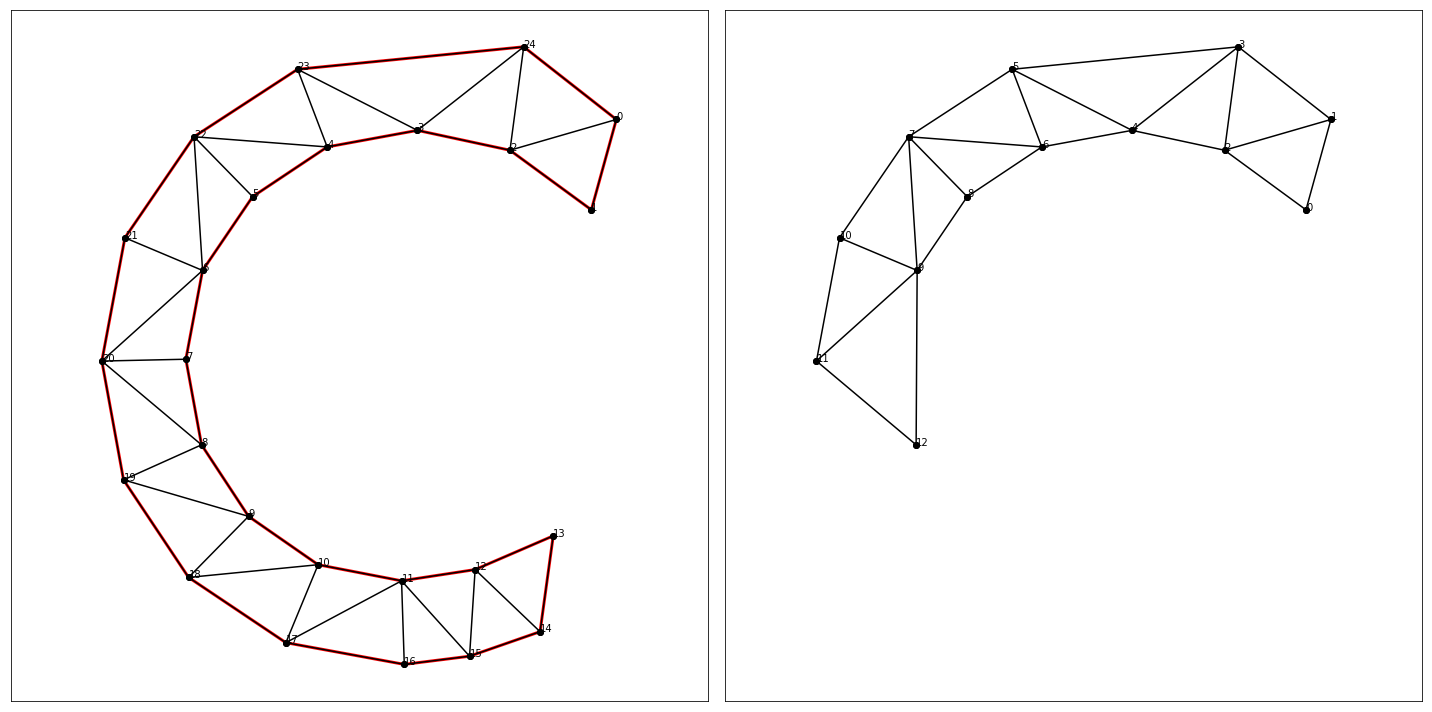

In [0]:
glyph['labels']=1
triangles['labels']=1
tr.compare(plt, glyph, triangles, figsize=(20,10))
plt.show()

[2 2 2 1 4 5 1 2 4 4 1 2 3 3 3 4 4 3 3 3 3 2 2 3 3 3 3 3 3]
[('vertices', 58), ('triangles', 126)]


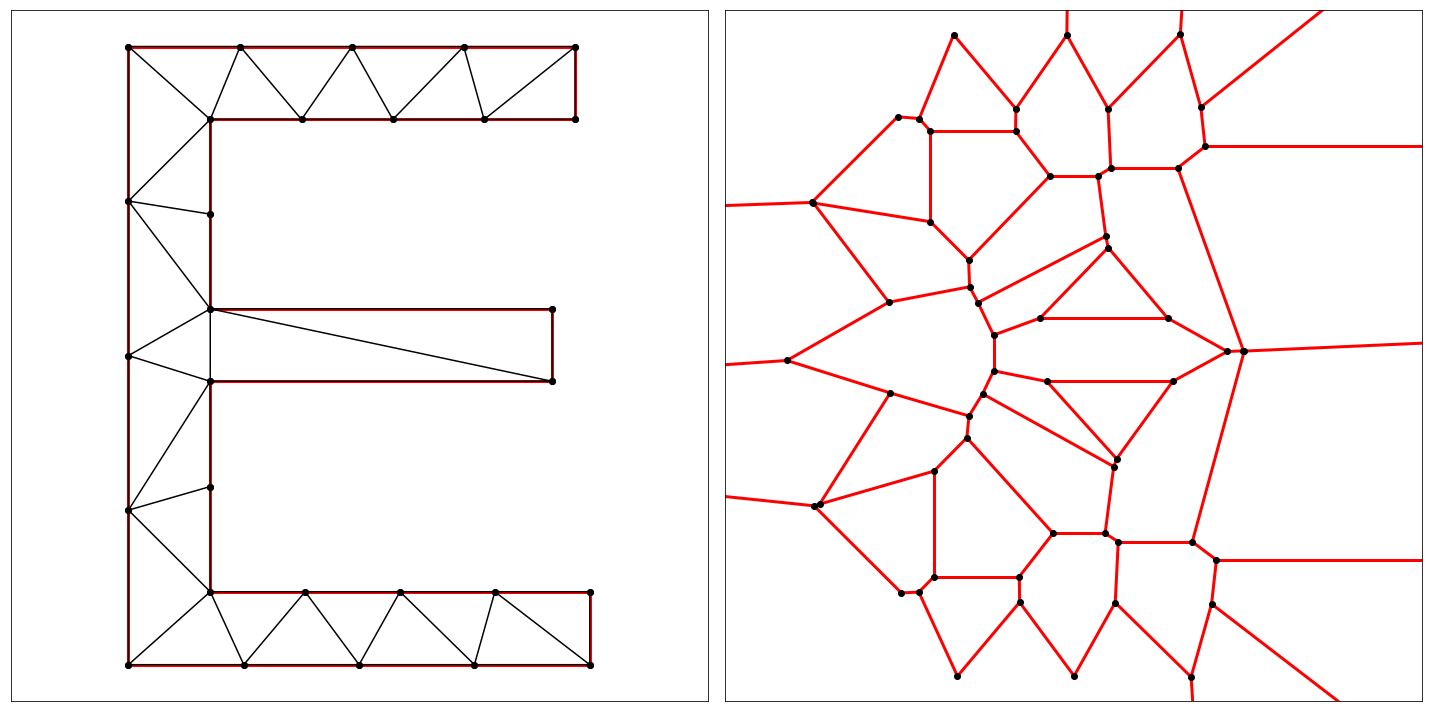

In [0]:
#title Try triangulating or calulcating voronio on just the vertices
glyph = nptris[0,glyphs.index('E')]
#print(glyph)
counts = np.bincount(glyph['triangles'].flatten())
print(counts)
#print(np.bincount(nptris[f,g]['triangles'].flatten()).sum())
T = {
  'vertices': glyph['vertices'],
#  'segments': np.array(segments),
}
#if holes:
#  T['holes'] = np.array(holes).reshape((-1,2))

opts = ''
#opts='p'  # PSLG (see https://rufat.be/triangle/delaunay.html)
#opts = 'q30' # conforming constrained Delaunay triangulation of a PSLG 
#opts = 'D' # conforming Delaunay triangulation 
tris = tr.triangulate(T, opts)
del tris['vertex_markers']
tris['labels']=1
print([(k, v.size) for k,v in tris.items() if isinstance(v, np.ndarray)])
#tr.compare(plt, glyph, tris, figsize=(20,10))
#plt.show()

points, edges, ray_origin, ray_direct = tr.voronoi(glyph['vertices'])
#points2, edges2, ray_origin2, ray_direct2 = tr.voronoi(points)
tr.compare(plt, glyph, {'vertices': points2, 'segments':edges2}, figsize=(20,10))
plt.show()

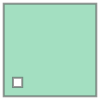

False
True


In [0]:
#title Try debugging shapely contains()
g1=shapely.geometry.LinearRing([(0, 0), (10, 0), (10, 10), (0,10)])
g2=shapely.geometry.LinearRing([(1,1),(2,1),(2,2),(1,2)])
display(shapely.geometry.Polygon(g1, [g2]))
print(g2.within(g1))  # ==False: see https://github.com/Toblerity/Shapely/issues/275
print(shapely.geometry.Polygon(g2).within(shapely.geometry.Polygon(g1))) # ==True

[(array([ 0.2 , -0.79]), array([ 0.2 , -0.78])), (array([ 0.2 , -0.78]), array([ 0.22, -0.77])), (array([ 0.22, -0.77]), array([ 0.25, -0.76])), (array([ 0.25, -0.76]), array([ 0.28, -0.7 ])), (array([ 0.28, -0.7 ]), array([ 0.49, -0.21])), (array([ 0.49, -0.21]), array([ 0.5 , -0.21])), (array([ 0.5 , -0.21]), array([ 0.74, -0.74])), (array([ 0.74, -0.74]), array([ 0.76, -0.76])), (array([ 0.76, -0.76]), array([ 0.77, -0.77])), (array([ 0.77, -0.77]), array([ 0.8 , -0.78])), (array([ 0.8 , -0.78]), array([ 0.8 , -0.79])), (array([ 0.8 , -0.79]), array([ 0.58, -0.79])), (array([ 0.58, -0.79]), array([ 0.58, -0.78])), (array([ 0.58, -0.78]), array([ 0.62, -0.77])), (array([ 0.62, -0.77]), array([ 0.63, -0.76])), (array([ 0.63, -0.76]), array([ 0.64, -0.74])), (array([ 0.64, -0.74]), array([ 0.62, -0.68])), (array([ 0.62, -0.68]), array([ 0.59, -0.6 ])), (array([ 0.59, -0.6 ]), array([ 0.36, -0.6 ])), (array([ 0.36, -0.6 ]), array([ 0.32, -0.71])), (array([ 0.32, -0.71]), array([ 0.31, -

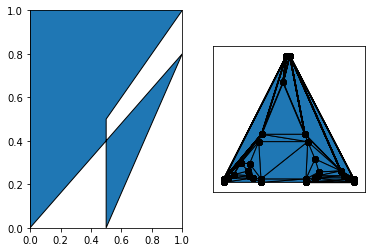

In [0]:
#title Try using shapely triangulate (but it doesn't support holes)
#points = shapely.geometry.MultiPoint([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])
A = tr.get_data('A')
print([(A["vertices"][s], A["vertices"][e]) for s,e in A["segments"]])
points = shapely.geometry.MultiPoint([A["vertices"][s] for s,e in A["segments"]])
triangles = shapely.ops.triangulate(points)
print([triangle.wkt for triangle in triangles])

ax1 = plt.subplot(122)
tr.plot(ax1,
        vertices=[p for poly in triangles for p in poly.exterior.coords],
        triangles=[(i, i+1, i+2) for i in range(len(triangles))]
       )
for poly in triangles:
  ax1.add_patch(descartes.PolygonPatch(poly))
# plt.show()

#fig = plt.figure(1, figsize=(5,5), dpi=90)
ring_mixed = shapely.geometry.Polygon([(0, 0), (0, 1.8), (1, 1), (.5, .5), (.5, 0), (1, 0.8), (0, 0)])
#ax = fig.add_subplot(111)
ax = plt.subplot(121)
ax.add_patch(descartes.PolygonPatch(ring_mixed))

plt.show()

In [0]:
# Sample from https://rufat.be/triangle/API.html

#A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
A = tr.get_data('A')
del A['vertex_attributes']
print(A.keys())
B = tr.triangulate(A, opts='p')
tr.compare(plt, A, B)
# #plt.figure()
# ax1 = plt.subplot(121)
# tr.plot(ax1, **A)
# lim = ax1.axis()
# ax2 = plt.subplot(122, sharey=ax1)
# tr.plot(ax2, **B)
# ax2.axis(lim)
# plt.tight_layout()
plt.show()